# Import Libraries

In [12]:
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [13]:
import pandas as pd
import matplotlib.pyplot as plt
import math
import numpy as np
import random
import builtins
import matplotlib.pyplot as plt
from sklearn.preprocessing import minmax_scale
from sklearn.model_selection import train_test_split

# Data Load


In [14]:
# Read the dataset from the specified path into a pandas DataFrame
df = pd.read_csv('/content/drive/MyDrive/CE889_Neural_Network_Data/DateForRocketGame/NormaliseDataforTest.csv')

# Display the cleaned DataFrame
df

,x_axis,y_axis,x_vector,y_vector
0,0.189355,0.502086,0.267957,0.151436
1,0.266847,0.413767,0.296758,0.076578
2,0.508577,0.566111,0.912636,0.500782
3,0.510723,0.610760,0.748296,0.553793
4,0.493721,0.664434,0.678820,0.486948
...,...,...,...,...
214585,0.431309,0.454201,0.409058,0.256371
214586,0.560160,0.493182,0.553314,0.646029
214587,0.510262,0.041448,0.996284,0.503637
214588,0.488503,0.606098,0.448432,0.304244


## Plotting Data

In [15]:
import seaborn as sns
import matplotlib.pyplot as plt

# Set the theme for Seaborn plots
sns.set_theme(style="ticks")

import seaborn as sns
import matplotlib.pyplot as plt

def plotData(data_frame):
    # Reduce the data size by taking a subset or downsampling
    data_subset = data_frame.iloc[::10]  # Take every 10th data point

    # Initialize Seaborn style
    sns.set(style="whitegrid")

    # Create a grid of subplots
    fig, axs = plt.subplots(2, 2, figsize=(12, 8))  # Adjust the size as needed

    # Loop through each column in the subset and plot on subplots
    columns = data_subset.columns  # Assuming there are exactly 4 columns

    for i, ax in enumerate(axs.flat):
        sns.lineplot(
            data=data_subset,
            x=data_subset.index,  # Assuming the index represents epochs
            y=columns[i],
            ax=ax,
            color="green",
            marker="o",
            linewidth=2,
        )
        ax.set_title(f"{columns[i]} vs Epochs", fontsize=14, fontweight="bold")
        ax.set_xlabel("Epochs", fontsize=12)
        ax.set_ylabel(columns[i], fontsize=12)

    # Adjust the layout for a clean appearance
    plt.tight_layout()

    # Show the plots
    plt.show()


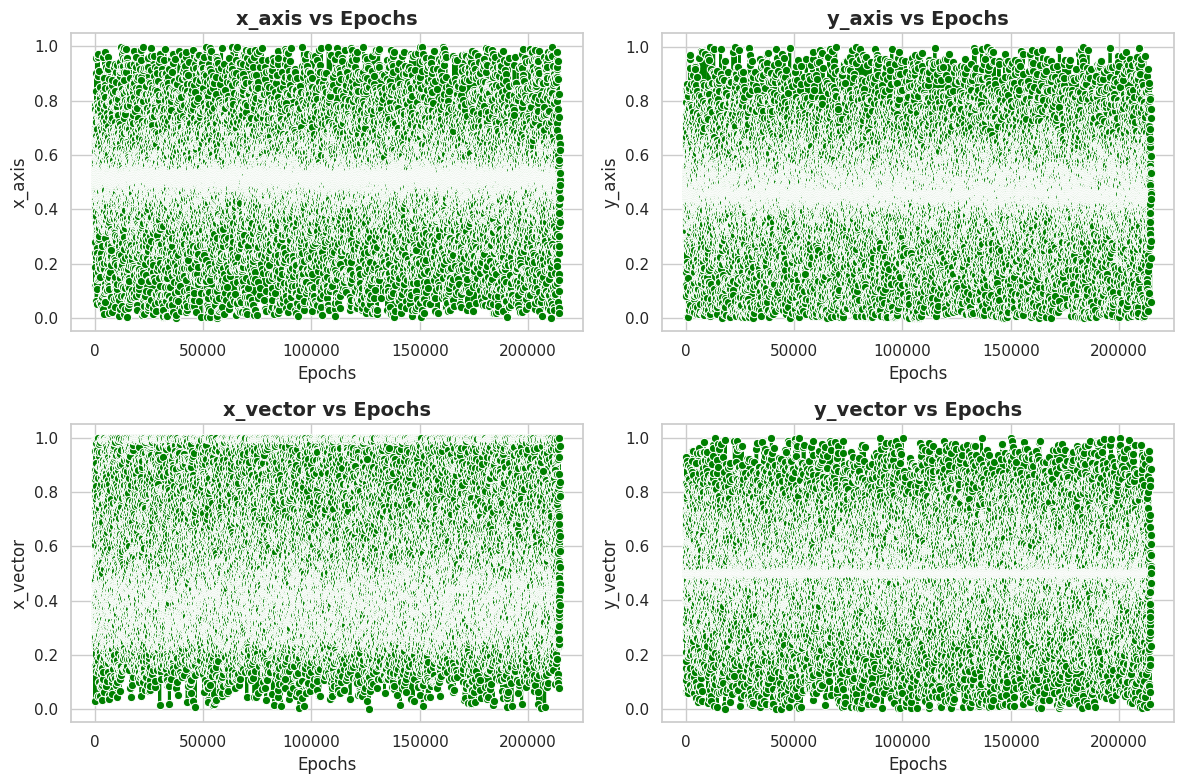

In [16]:
plotData(df)

# Declaring input layer, output layer, weights

In [17]:
input_layer = df.iloc[:, :2].values.tolist()
output_layer = df.iloc[:, 2:].values.tolist()

In [18]:
weights_input_hidden = [
    [-0.4975087791239208, 1.2016780567776557],  # Weights for the first hidden neuron
    [3.9012450597204755, 0.6675107395150763],  # Weights for the second hidden neuron
    [0.6128513501539625, 3.065091952905957],   # Weights for the third hidden neuron
    [-3.5016733284519157, 2.1910637285793113],   # Weights for the forth hidden neuron
]

# Weights from hidden layer to output layer (3 hidden neurons -> 2 outputs)
weights_hidden_output = [
    [1.8734472738086914, 3.3091160965286397, -4.627440859589065, 0.9073650328374685],  # Weights for the first output neuron
    [11.29275677095681, -2.9655732162924595, -2.0587018840082156, -4.757812016009509]   # Weights for the second output neuron
]

weights_input_hidden_prev = [[0 for _ in row] for row in weights_input_hidden]
weights_hidden_output_prev = [[0 for _ in row] for row in weights_hidden_output]
gradient_list = [[0] * len(weights_input_hidden)] + [[0, 0]]

learning_rate = 0.1
M =  0.1  # Momentum term.
epsilon = 1e-6  # Small value to avoid numerical instability

# Feed Forward

In [19]:
def sigmoidCalc(v):
    lambdaVal = 0.9
    if v > 100:  # Prevent overflow
        return 1.0
    elif v < -100:  # Prevent underflow
        return 0.0
    return 1 / (1 + math.exp(-lambdaVal * v))

In [20]:
def layerValCalc(input_layer, weights):
    # Initialize an empty list to store the calculated values for each neuron in the layer
    layer = []

    # Iterate through each neuron in the layer (corresponding to each row in weights)
    for i in range(len(weights)):
        # Initialize the sum for the current neuron's weighted sum (layer_val)
        layer_val = 0

        # Iterate through each input value (for each input to the neuron)
        for j in range(len(weights[i])):
            # Multiply the input value by the corresponding weight and add it to the current layer value
            layer_val += input_layer[j] * weights[i][j]

        # Append the calculated value for this neuron to the layer list
        layer.append(layer_val)

    # Return the list of calculated values (output of the layer)
    return layer

In [21]:
def feed_forward(input_layer_val):
    # Initialize an empty list to store the outputs of each layer
    outputs = []

    # Initialize variable v to store the output values from each layer
    v = 0

    # Iterate through the two layers: 1 hidden layer and 1 output layer
    for i in range(2):
        if i == 0:
            # Calculate the values for the hidden layer (using input to hidden weights)
            v = layerValCalc(input_layer_val, weights_input_hidden)
        else:
            # Calculate the values for the output layer (using hidden to output weights)
            v = layerValCalc(input_layer_val, weights_hidden_output)

        # If it's not the output layer, apply the sigmoid activation function (for the hidden layer)
        if i != 1:
            # For the hidden layer, apply the sigmoid activation function to each value in v
            hidden_outputs = [sigmoidCalc(val) for val in v]
        else:
            # For the output layer, no activation function is applied (this can be changed as needed)
            hidden_outputs = v

        # Set the output of the current layer as the input for the next layer
        input_layer_val = hidden_outputs

        # Append the current layer's output to the outputs list
        outputs.append(hidden_outputs)

    # Return the outputs of all layers (hidden and output)
    return outputs

# Error Calculation

In [22]:
# Initialize an empty list to store RMSE values
rmse_values = []

for it in range(250):

    # Accumulators for squared errors
    sum_squared_error_y1 = 0
    sum_squared_error_y2 = 0


    for indx in range(len(input_layer)):
        outputs = feed_forward(input_layer[indx])

        # Calculate errors for the output layer
        errors = [output_layer[indx][i] - outputs[-1][i] for i in range(len(output_layer[indx]))]

        # Accumulate squared errors for RMSE calculation
        sum_squared_error_y1 += errors[0] ** 2
        sum_squared_error_y2 += errors[1] ** 2


    # Calculate RMSE for each output
    rmse_y1 = math.sqrt(sum_squared_error_y1 / len(input_layer))
    rmse_y2 = math.sqrt(sum_squared_error_y2 / len(input_layer))

    # Average RMSE across both outputs
    rmse = (rmse_y1 + rmse_y2) / 2
    # Store RMSE for plotting
    rmse_values.append(rmse)

    print(f"Iteration: {it + 1}, RMSE: {rmse:.6f}")

Iteration: 1, RMSE: 0.146012
Iteration: 2, RMSE: 0.146012
Iteration: 3, RMSE: 0.146012
Iteration: 4, RMSE: 0.146012
Iteration: 5, RMSE: 0.146012
Iteration: 6, RMSE: 0.146012
Iteration: 7, RMSE: 0.146012
Iteration: 8, RMSE: 0.146012
Iteration: 9, RMSE: 0.146012
Iteration: 10, RMSE: 0.146012
Iteration: 11, RMSE: 0.146012
Iteration: 12, RMSE: 0.146012
Iteration: 13, RMSE: 0.146012
Iteration: 14, RMSE: 0.146012
Iteration: 15, RMSE: 0.146012
Iteration: 16, RMSE: 0.146012
Iteration: 17, RMSE: 0.146012
Iteration: 18, RMSE: 0.146012
Iteration: 19, RMSE: 0.146012
Iteration: 20, RMSE: 0.146012
Iteration: 21, RMSE: 0.146012
Iteration: 22, RMSE: 0.146012
Iteration: 23, RMSE: 0.146012
Iteration: 24, RMSE: 0.146012
Iteration: 25, RMSE: 0.146012
Iteration: 26, RMSE: 0.146012
Iteration: 27, RMSE: 0.146012
Iteration: 28, RMSE: 0.146012
Iteration: 29, RMSE: 0.146012
Iteration: 30, RMSE: 0.146012
Iteration: 31, RMSE: 0.146012
Iteration: 32, RMSE: 0.146012
Iteration: 33, RMSE: 0.146012
Iteration: 34, RMSE

# RMSE

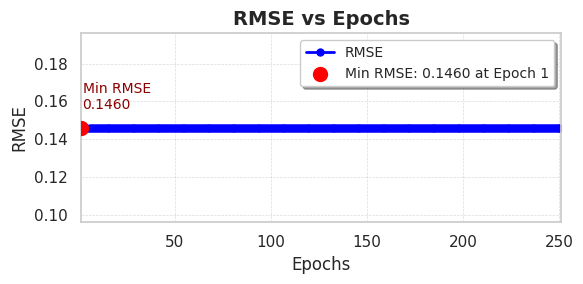

In [23]:
# Detect the minimum RMSE and its corresponding epoch
min_rmse = builtins.min(rmse_values)
min_epoch = rmse_values.index(min_rmse) + 1  # Adding 1 for 1-based indexing

# Plot RMSE vs Epochs
plt.figure(figsize=(6, 3))  # Medium-sized graph
plt.plot(range(1, len(rmse_values) + 1), rmse_values,
         label="RMSE", color="blue", linewidth=2, marker="o", markersize=5)

# Highlight the minimum RMSE point
plt.scatter(min_epoch, min_rmse, color="red", s=100, zorder=5, label=f"Min RMSE: {min_rmse:.4f} at Epoch {min_epoch}")

# Add annotations for the minimum RMSE point
plt.annotate(f"Min RMSE\n{min_rmse:.4f}",
             xy=(min_epoch, min_rmse), xycoords='data',
             xytext=(min_epoch + 1, min_rmse + 0.01), textcoords='data',
             arrowprops=dict(facecolor='black', arrowstyle='->'),
             fontsize=10, color="darkred")

# Add gridlines, titles, and labels
plt.title("RMSE vs Epochs", fontsize=14, fontweight="bold")
plt.xlabel("Epochs", fontsize=12)
plt.ylabel("RMSE", fontsize=12)
plt.grid(visible=True, linestyle='--', linewidth=0.5, alpha=0.7)

# Add a legend and customize its style
plt.legend(loc="upper right", fontsize=10, frameon=True, shadow=True)

# Adjust axis limits for better spacing
plt.xlim(1, len(rmse_values) + 1)
plt.ylim(builtins.min(rmse_values) - 0.05, builtins.max(rmse_values) + 0.05)

# Show the graph
plt.tight_layout()
plt.show()


# Getting the weights

In [24]:
print(weights_input_hidden)

[[-0.4975087791239208, 1.2016780567776557], [3.9012450597204755, 0.6675107395150763], [0.6128513501539625, 3.065091952905957], [-3.5016733284519157, 2.1910637285793113]]


In [25]:
print(weights_hidden_output)

[[1.8734472738086914, 3.3091160965286397, -4.627440859589065, 0.9073650328374685], [11.29275677095681, -2.9655732162924595, -2.0587018840082156, -4.757812016009509]]
